<a href="https://colab.research.google.com/github/wakkihaya/mne-oscillation-classifier/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# This script demonstrates that it 

# See:// https://mne.tools/dev/auto_examples/time_frequency/time_frequency_global_field_power.html
import os.path as op

import numpy as np
import matplotlib.pyplot as plt

import mne
from mne.datasets import somato
from mne.baseline import rescale
from mne.stats import bootstrap_confidence_interval

In [3]:
data_path = somato.data_path()
subject = '01'
task = 'somato'
raw_fname = op.join(data_path, 'sub-{}'.format(subject), 'meg',
                    'sub-{}_task-{}_meg.fif'.format(subject, task))

# let's explore some frequency bands
iter_freqs = [
    ('Theta', 4, 7),
    ('Alpha', 8, 12),
    ('Beta', 13, 25),
    ('Gamma', 30, 45)
]

In [4]:
# set epoching parameters
event_id, tmin, tmax = 1, -1., 3.
baseline = None

# get the header to extract events
raw = mne.io.read_raw_fif(raw_fname)
events = mne.find_events(raw, stim_channel='STI 014')

frequency_map = list()

for band, fmin, fmax in iter_freqs:
    # (re)load the data to save memory
    raw = mne.io.read_raw_fif(raw_fname)
    raw.pick_types(meg='grad', eeg=True, eog=False)  
    raw.load_data()
    

    # bandpass filter
    raw.filter(fmin, fmax, n_jobs=1,  # use more jobs to speed up.
               l_trans_bandwidth=1,  # make sure filter params are the same
               h_trans_bandwidth=1)  # in each band and skip "auto" option.

    # epoch
    epochs = mne.Epochs(raw, events, event_id, tmin, tmax, baseline=baseline,
                        reject=dict(grad=4000e-13),
                        preload=True)
    # remove evoked response
    epochs.subtract_evoked()

    # get analytic signal (envelope)
    epochs.apply_hilbert(envelope=True)
    frequency_map.append(((band, fmin, fmax), epochs.average()))
    del epochs
del raw

Opening raw data file /Users/wakkihaya/mne_data/MNE-somato-data/sub-01/meg/sub-01_task-somato_meg.fif...
    Range : 237600 ... 506999 =    791.189 ...  1688.266 secs
Ready.
111 events found
Event IDs: [1]
Opening raw data file /Users/wakkihaya/mne_data/MNE-somato-data/sub-01/meg/sub-01_task-somato_meg.fif...
    Range : 237600 ... 506999 =    791.189 ...  1688.266 secs
Ready.
Reading 0 ... 269399  =      0.000 ...   897.077 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 4 - 7 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 4.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 3.50 Hz)
- Upper passband edge: 7.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 7.50 Hz)
- Filter length: 993 samples (3.307 sec)

Not 

Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)
Applying baseline correction (mode: mean)


Text(0.5, 0, 'Time [ms]')

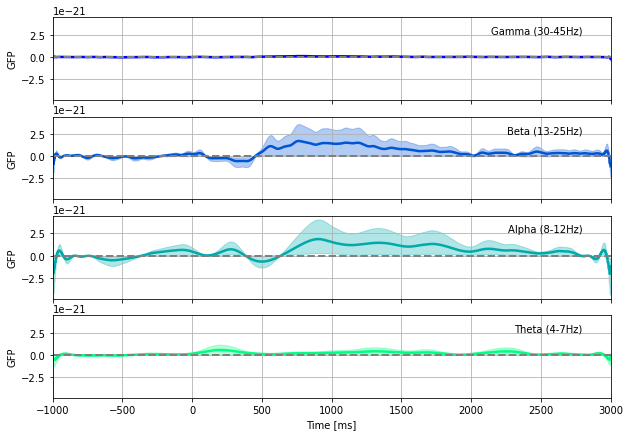

In [5]:
# Helper function for plotting spread
def stat_fun(x):
    """Return sum of squares."""
    return np.sum(x ** 2, axis=0)


# Plot
fig, axes = plt.subplots(4, 1, figsize=(10, 7), sharex=True, sharey=True)
colors = plt.get_cmap('winter_r')(np.linspace(0, 1, 4))
for ((freq_name, fmin, fmax), average), color, ax in zip(
        frequency_map, colors, axes.ravel()[::-1]):
    times = average.times * 1e3
    gfp = np.sum(average.data ** 2, axis=0)
    gfp = mne.baseline.rescale(gfp, times, baseline=(None, 0))
    ax.plot(times, gfp, label=freq_name, color=color, linewidth=2.5)
    ax.axhline(0, linestyle='--', color='grey', linewidth=2)
    ci_low, ci_up = bootstrap_confidence_interval(average.data, random_state=0,
                                                  stat_fun=stat_fun)
    ci_low = rescale(ci_low, average.times, baseline=(None, 0))
    ci_up = rescale(ci_up, average.times, baseline=(None, 0))
    ax.fill_between(times, gfp + ci_up, gfp - ci_low, color=color, alpha=0.3)
    ax.grid(True)
    ax.set_ylabel('GFP')
    ax.annotate('%s (%d-%dHz)' % (freq_name, fmin, fmax),
                xy=(0.95, 0.8),
                horizontalalignment='right',
                xycoords='axes fraction')
    ax.set_xlim(-1000, 3000)

axes.ravel()[-1].set_xlabel('Time [ms]')

In [6]:
# Apply machine learning: Classify it's alpha or not.
# Train data : alpha and beta data filitering by fliter command.
# Test data: random data not filtering.
alpha_freq = iter_freqs[1]
raw = mne.io.read_raw_fif(raw_fname)
events = mne.find_events(raw, stim_channel='STI 014')
raw.pick_types(meg='grad', eeg=True, eog=False)  
raw.load_data()

 # bandpass filter for alpha
raw.filter(alpha_freq[1], alpha_freq[2], n_jobs=1,  # use more jobs to speed up.
             l_trans_bandwidth=1,  # make sure filter params are the same
              h_trans_bandwidth=1)  # in each band and skip "auto" option.

# epoch with alpha data.
epochs_train_alpha = mne.Epochs(raw, events, event_id, tmin, tmax, baseline=baseline,
                        reject=dict(grad=4000e-13),
                        preload=True)
# remove evoked response
epochs_train_alpha.subtract_evoked()

del raw

beta_freq = iter_freqs[2]
raw = mne.io.read_raw_fif(raw_fname)
events = mne.find_events(raw, stim_channel='STI 014')
raw.pick_types(meg='grad', eeg=True, eog=False)  
raw.load_data()

# bandpass filter for beta
raw.filter(beta_freq[1], beta_freq[2], n_jobs=1,  # use more jobs to speed up.
             l_trans_bandwidth=1,  # make sure filter params are the same
              h_trans_bandwidth=1)  # in each band and skip "auto" option.

# epoch with beta data.
epochs_train_beta = mne.Epochs(raw, events, event_id, tmin, tmax, baseline=baseline,
                        reject=dict(grad=4000e-13),
                        preload=True)

# remove evoked response
epochs_train_beta.subtract_evoked()

del raw


Opening raw data file /Users/wakkihaya/mne_data/MNE-somato-data/sub-01/meg/sub-01_task-somato_meg.fif...
    Range : 237600 ... 506999 =    791.189 ...  1688.266 secs
Ready.
111 events found
Event IDs: [1]
Reading 0 ... 269399  =      0.000 ...   897.077 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 8 - 12 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 7.50 Hz)
- Upper passband edge: 12.00 Hz
- Upper transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 12.50 Hz)
- Filter length: 993 samples (3.307 sec)

Not setting metadata
Not setting metadata
111 matching events found
No baseline correction applied
0 projection items activated
Loading data for 111 events and 1202 original t

Number of events,111
Events,1: 111
Time range,-0.999 – 3.000 sec
Baseline,off


In [25]:
epochs_train_alpha_data=epochs_train_alpha.get_data() #[n_epochs, n_channels, n_times]
epochs_train_beta_data=epochs_train_beta.get_data()
class0 = np.zeros((epochs_train_alpha_data.shape[0],1))
class1 = np.ones((epochs_train_beta_data.shape[0],1))
epochs_train_alpha_data=epochs_train_alpha_data.reshape(len(class0), -1)
epochs_train_beta_data= epochs_train_beta_data.reshape(len(class1), -1)

In [26]:
X = np.concatenate((epochs_train_alpha_data,epochs_train_beta_data), axis= 0)
Y = np.concatenate((class0, class1), axis =0)

In [27]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y)

In [28]:
from sklearn import svm

clf = svm.SVC()
clf.fit(X_train,Y_train)

/Users/wakkihaya/.pyenv/versions/3.9.4/lib/python3.9/site-packages/sklearn/utils/validation.py:72: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(**kwargs)


SVC()

In [29]:
y_hat = clf.predict(X_test)
print(y_hat)

[0. 1. 0. 1. 1. 1. 1. 1. 1. 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 1. 1. 1. 0. 0.
 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1.
 1. 1. 0. 1. 1. 0. 0. 0.]


In [30]:
from sklearn.metrics import accuracy_score
accuracy_score(Y_test, y_hat)

0.8571428571428571